# Tensorflow Expedia plus features

In [1]:
import os
import pprint
import tempfile

from typing import Dict, Text

import datetime as dt

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd

import tensorflow_recommenders as tfrs

In [ ]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Load data

In [3]:
data_dir = '../../data/expedia/'

def convert_date(date_col):
    return (pd.to_datetime(date_col) - dt.datetime(1970,1,1)).dt.total_seconds()

def create_tf_datasets(filename: str):
        
    df = pd.read_csv(data_dir + filename)
    
    # Convert date to unix timestamp
    df['date_time'] = convert_date(df['date_time'])
    
    # Convert to bytes
    df['user_id'] = [bytes(str(uid), 'utf-8') for uid in df['user_id']]
    df['hotel_cluster'] = [bytes(str(uid), 'utf-8') for uid in df['hotel_cluster']]
    
    features = df.drop(['cnt', 'srch_ci', 'srch_co'], axis=1)
    
    # Create tf datasets
    dataset = tf.data.Dataset.from_tensor_slices((dict(features))) 
    hotels = tf.data.Dataset.from_tensor_slices([bytes(str(uid), 'utf-8') for uid in range(0, 99)])
    
    # Column selection
    dataset = dataset.map(lambda x: {
        "hotel_cluster": x["hotel_cluster"],
        "user_id": x["user_id"],
        "is_package" : x["is_package"],
    })
    
    return dataset, hotels, len(df)
    
    

In [4]:
filename = 'train_sample' # 'train_sample'

dataset, hotels, n_records = create_tf_datasets(f'{filename}.csv')

In [5]:
for x in dataset.take(1).as_numpy_iterator():
    pprint.pprint(x)

{'hotel_cluster': b'15', 'is_package': 0, 'user_id': b'472333'}


In [6]:
user_ids = dataset.batch(1_000_000).map(lambda x: x["user_id"])
hotel_clusters = hotels.batch(1_000_000)

unique_user_ids = np.unique(np.concatenate(list(user_ids)))
unique_hotel_clusters = np.unique(np.concatenate(list(hotel_clusters)))

unique_hotel_clusters[:10]

array([b'0', b'1', b'10', b'11', b'12', b'13', b'14', b'15', b'16', b'17'],
      dtype=object)

In [7]:
is_package = np.concatenate(list(dataset.map(lambda x: x["is_package"]).batch(100)))

## Model

Indicator columns and embedding columns never work on features directly

https://keras.io/guides/preprocessing_layers/

In [8]:
class UserModel(tf.keras.Model):
  
    def __init__(self):
        super().__init__()

        self.user_embedding = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.StringLookup(
                vocabulary=unique_user_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_user_ids) + 1, 32),
        ])

        self.package_encoder = (tf.keras
                                .layers.experimental
                                .preprocessing
                                .CategoryEncoding(output_mode="binary"))
        
        self.package_encoder.adapt(is_package)


    def call(self, inputs):

        return tf.concat([
            self.user_embedding(inputs["user_id"]),
            self.package_encoder(inputs["is_package"]),
        ], axis=1)

In [9]:
# Candidate tower
class HotelClusterModel(tf.keras.Model):
    
    def __init__(self):
        super().__init__()
        
        self.hotel_clusters = tf.keras.Sequential([
          tf.keras.layers.experimental.preprocessing.StringLookup(
          vocabulary=unique_hotel_clusters, mask_token=None),
          tf.keras.layers.Embedding(len(unique_hotel_clusters) + 1, embedding_dimension)
        ])
        
    def call(self, hotel_cluster):
        return self.hotel_clusters(hotel_cluster) 


In [10]:
embedding_dimension = 32

# top K categorical accuracy: how often the true candidate is in the top K candidates for a given query.


In [15]:
class ExpediaModel(tfrs.Model):

    def __init__(self):
        super().__init__()
        self.hotel_cluster_model: tf.keras.Model = HotelClusterModel()
                    
        self.user_model: tf.keras.Model = tf.keras.Sequential([
          UserModel(),
          tf.keras.layers.Dense(32)
        ])
        
        metrics = tfrs.metrics.FactorizedTopK(
          candidates=hotels.batch(128).map(self.hotel_cluster_model)
        )

        self.task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
          metrics=metrics
        )

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        # We pick out the user features and pass them into the user model.
        user_embeddings = self.user_model({
            "user_id": features["user_id"],
            "is_package": features["is_package"],
        })
        # And pick out the movie features and pass them into the movie model,
        # getting embeddings back.
        positive_hotel_clusters = self.hotel_cluster_model(features['hotel_cluster'])

        # The task computes the loss and the metrics.
        return self.task(user_embeddings, positive_hotel_clusters)

In [16]:
model = ExpediaModel()
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

In [17]:
# TODO timesplit
tf.random.set_seed(42)
shuffled = dataset.shuffle(n_records, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(int(0.9 * n_records))
test = shuffled.skip(int(0.9* n_records)).take(int(0.1 * n_records))

cached_train = train.batch(8192).cache()
cached_test = test.batch(4096).cache()

In [18]:
fitted_model = model.fit(cached_train, 
          validation_data=cached_test,
          validation_freq=1,
          epochs=2)

Epoch 1/2
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
55/55 [==============================] - ETA: 0s - factorized_top_k: 0.3822 - factorized_top_k/top_1_categorical_accuracy: 0.0158 - factorized_top_k/top_5_categorical_accuracy: 0.0922 - factorized_top_k/top_10_categorical_accuracy: 0.1688 - factorized_top_k/top_50_categorical_accuracy: 0.6343 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 73091.8685 - regularization_loss: 0.0000e+00 - total_loss: 73091.8685WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'user_id': <tf.Tensor 'IteratorGetNext:2' shape=(None,) dtype=string>, 'is_package': <tf.Tensor 'IteratorGetNext:1' shape=(None,) dtype=int64>}
Consider rewriting this model with the Functional API.
55/55 [==============================] - 36s 655ms/step - factorized_top_k: 0.3822 - factorized_top_k/top_1_categorical_accura

In [19]:
model.evaluate(cached_test, return_dict=True)

13/13 [==============================] - 1s 111ms/step - factorized_top_k: 0.3977 - factorized_top_k/top_1_categorical_accuracy: 0.0245 - factorized_top_k/top_5_categorical_accuracy: 0.1113 - factorized_top_k/top_10_categorical_accuracy: 0.1937 - factorized_top_k/top_50_categorical_accuracy: 0.6593 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 31764.9893 - regularization_loss: 0.0000e+00 - total_loss: 31764.9893


{'factorized_top_k': array([0.02446, 0.11132, 0.19366, 0.65928, 1.     ], dtype=float32),
 'factorized_top_k/top_1_categorical_accuracy': 0.024460000917315483,
 'factorized_top_k/top_5_categorical_accuracy': 0.11131999641656876,
 'factorized_top_k/top_10_categorical_accuracy': 0.19366000592708588,
 'factorized_top_k/top_50_categorical_accuracy': 0.659280002117157,
 'factorized_top_k/top_100_categorical_accuracy': 1.0,
 'loss': 6175.3623046875,
 'regularization_loss': 0,
 'total_loss': 6175.3623046875}

Top-5 accuracy: 0.11.


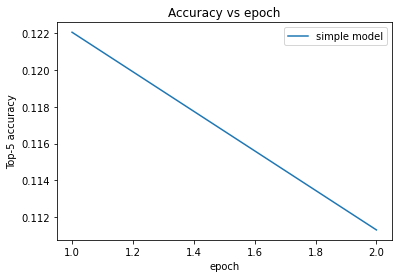

In [20]:
accuracy = fitted_model.history["val_factorized_top_k/top_5_categorical_accuracy"][-1]
print(f"Top-5 accuracy: {accuracy:.2f}.")

num_validation_runs = len(fitted_model.history["val_factorized_top_k/top_5_categorical_accuracy"])
epochs = [(x + 1)* 1 for x in range(num_validation_runs)]

plt.plot(epochs, fitted_model.history["val_factorized_top_k/top_5_categorical_accuracy"], label="simple model")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-5 accuracy");
plt.legend();

In [167]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [170]:
# Save model
query_path = os.path.join('./models/', f"{filename}_package_query_model")
model.user_model.save(query_path)

candidate_path = os.path.join('./models/', f"{filename}_package_candidate_model")
model.hotel_cluster_model.save(candidate_path)

In [ ]:
# Load model
user_model = tf.keras.models.load_model(query_path)

candidate_model = tf.keras.models.load_model(candidate_path)
query_embedding = user_model(tf.constant(["10"]))

## Predictions

### Brute Force

In [21]:
# Create a model that takes in raw query features, and
index = tfrs.layers.ann.BruteForce(query_model=model.user_model)

hotel_cluster_embeddings = hotels.batch(100).map(model.hotel_cluster_model)

# recommends hotels from all hotel clusters.
index.index(candidates=hotel_cluster_embeddings, 
            identifiers=hotels)

prediction_file = 'test.csv' # train_sample.csv test.csv
users_to_predict = pd.read_csv(data_dir + prediction_file)[['user_id', 'is_package']]

In [22]:
list(dataset.take(1))

[{'hotel_cluster': <tf.Tensor: shape=(), dtype=string, numpy=b'15'>,
  'user_id': <tf.Tensor: shape=(), dtype=string, numpy=b'472333'>,
  'is_package': <tf.Tensor: shape=(), dtype=int64, numpy=0>}]

In [23]:
_, hotel_cluster = index(queries={'user_id':tf.constant(["472333"]), 
                                   'is_package': tf.constant([1])})
print(f"Recommendations for user 472333: {hotel_cluster[0, :3]}")

Consider rewriting this model with the Functional API.
Recommendations for user 472333: [b'15' b'10' b'76']


In [24]:
users_to_predict

,user_id,is_package
0,1,0
1,1,0
2,20,0
3,28,1
4,50,0
...,...,...
2528238,1198754,0
2528239,1198758,0
2528240,1198771,0
2528241,1198775,0


In [ ]:
results = []

for i, user in users_to_predict.iterrows():
    _, hotel_clusters = index(queries={'user_id':tf.constant([str(user['user_id'])]), 
                                       'is_package': tf.constant([user['is_package']])})
    results.append({'user_id': user['user_id'], 'hotel cluster' : [int(i) for i in hotel_clusters[0, :5].numpy()]})
    if i % 1_000 == 0:
        print(f"Parsed {i} users.")

Parsed 0 users.
Parsed 1000 users.
Parsed 2000 users.
Parsed 3000 users.
Parsed 4000 users.
Parsed 5000 users.
Parsed 6000 users.
Parsed 7000 users.
Parsed 8000 users.
Parsed 9000 users.
Parsed 10000 users.
Parsed 11000 users.
Parsed 12000 users.
Parsed 13000 users.
Parsed 14000 users.
Parsed 15000 users.
Parsed 16000 users.
Parsed 17000 users.
Parsed 18000 users.
Parsed 19000 users.
Parsed 20000 users.
Parsed 21000 users.
Parsed 22000 users.
Parsed 23000 users.
Parsed 24000 users.
Parsed 25000 users.
Parsed 26000 users.
Parsed 27000 users.
Parsed 28000 users.
Parsed 29000 users.
Parsed 30000 users.
Parsed 31000 users.
Parsed 32000 users.
Parsed 33000 users.
Parsed 34000 users.
Parsed 35000 users.
Parsed 36000 users.
Parsed 37000 users.
Parsed 38000 users.
Parsed 39000 users.
Parsed 40000 users.
Parsed 41000 users.
Parsed 42000 users.
Parsed 43000 users.
Parsed 44000 users.
Parsed 45000 users.
Parsed 46000 users.
Parsed 47000 users.
Parsed 48000 users.
Parsed 49000 users.
Parsed 50000 

Parsed 396000 users.
Parsed 397000 users.
Parsed 398000 users.
Parsed 399000 users.
Parsed 400000 users.
Parsed 401000 users.
Parsed 402000 users.
Parsed 403000 users.
Parsed 404000 users.
Parsed 405000 users.
Parsed 406000 users.
Parsed 407000 users.
Parsed 408000 users.
Parsed 409000 users.
Parsed 410000 users.
Parsed 411000 users.
Parsed 412000 users.
Parsed 413000 users.
Parsed 414000 users.
Parsed 415000 users.
Parsed 416000 users.
Parsed 417000 users.
Parsed 418000 users.
Parsed 419000 users.
Parsed 420000 users.
Parsed 421000 users.
Parsed 422000 users.
Parsed 423000 users.
Parsed 424000 users.
Parsed 425000 users.
Parsed 426000 users.
Parsed 427000 users.
Parsed 428000 users.
Parsed 429000 users.
Parsed 430000 users.
Parsed 431000 users.
Parsed 432000 users.
Parsed 433000 users.
Parsed 434000 users.
Parsed 435000 users.
Parsed 436000 users.
Parsed 437000 users.
Parsed 438000 users.
Parsed 439000 users.
Parsed 440000 users.
Parsed 441000 users.
Parsed 442000 users.
Parsed 443000

KeyboardInterrupt: 

In [ ]:
pd.DataFrame(results).to_csv('results_607000.csv')

In [41]:
import pickle
with open("results_607_000.txt", "wb") as fp:   #Pickling
    pickle.dump(results, fp)